# Import Library dan Setup

In [1]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.6 MB/s eta 0:00:00


In [2]:
# Import library
import pandas as pd
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig, Trainer, TrainingArguments
from torch.utils.data import Dataset
from nlpaug.augmenter.word import SynonymAug
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
import random
from transformers import pipeline

- pandas dan numpy: Digunakan untuk memanipulasi dan menganalisis dataset  seperti pembersihan data dan augmentasi.

- re: Untuk pembersihan teks (menghapus URL) menggunakan regular expression.

- torch: Untuk mendukung operasi tensor dalam pelatihan model DistilBERT dan penanganan class weights.

- sklearn: Menyediakan fungsi untuk splitting data (train_test_split) dan evaluasi model (metrik seperti accuracy_score, confusion_matrix).

- transformers: Menyediakan model DistilBERT (DistilBertTokenizer, DistilBertForSequenceClassification), pelatihan (Trainer), dan augmentasi berbasis terjemahan (pipeline).

- matplotlib dan seaborn: Untuk visualisasi confusion matrix, membantu analisis performa model.

- os: Untuk mengatur lingkungan, seperti menonaktifkan Weights & Biases (W&B).

- nltk dan random: Untuk mendukung pemrosesan teks dan pengacakan (meskipun nltk hanya digunakan untuk mengunduh sumber daya).

- pipeline: Untuk back-translation menggunakan model Helsinki-NLP.


In [3]:
# Nonaktifkan W&B
os.environ["WANDB_DISABLED"] = "true"

- Menonaktifkan W&B untuk mencegah pelacakan eksperimen secara otomatis, yang tidak diperlukan dalam proyek ini.

- Mengurangi overhead komputasi dan menghindari keharusan login ke W&B


In [4]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

- Mengunduh model tagger bahasa Inggris untuk nltk, yang diperlukan oleh nlpaug.SynonymAug untuk augmentasi sinonim berdasarkan part-of-speech.


# Informasi Dataset

In [5]:
# Load dataset
df = pd.read_csv('dataset_baru.csv')
df.head()

,nama,rating,waktu,label,review
0,Adi,5,1 minggu lalu,OR,Yang ini belum dicoba
1,Hilma,5,1 minggu lalu,OR,pesanan sesuai terima kasih
2,H***y,5,3 minggu lalu,OR,terima kasih atas bonusnya
3,I***d,5,1 bulan lalu,OR,terima kasih
4,S***f,5,1 bulan lalu,OR,"Respon seller cepat dan ramah, packing rapi, p..."


- Memuat dan memeriksa struktur data (kolom dan beberapa baris awal)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nama    885 non-null    object
 1   rating  887 non-null    object
 2   waktu   887 non-null    object
 3   label   887 non-null    object
 4   review  887 non-null    object
dtypes: object(5)
memory usage: 34.8+ KB


- Menampilkan informasi dataset, seperti jumlah baris, kolom, tipe data, dan nilai yang hilang (missing values).

In [7]:
df = df[['review', 'label']].dropna()

- Memilih hanya kolom review (teks ulasan) dan label (CG/OR) yang relevan untuk tugas klasifikasi, mengabaikan kolom lain yang tidak diperlukan.

In [8]:
df.describe()

,review,label
count,887,887
unique,807,2
top,semoga cocok,CG
freq,12,699


In [9]:
# Cek dan hapus duplikasi
print("Jumlah duplikasi:", df.duplicated().sum())
df = df.drop_duplicates()

Jumlah duplikasi: 72


- Dilakukan karena ulasan duplikat dapat menyebabkan bias dalam pelatihan, membuat model overfit pada pola berulang dan mengurangi kemampuan generalisasi.

In [10]:
# Cek distribusi kelas
print(df['label'].value_counts())

label
CG    656
OR    159
Name: count, dtype: int64


- Dataset tidak seimbang (lebih banyak CG/palsu daripada OR/asli), yang dapat membuat model cenderung memprediksi kelas mayoritas (CG).

# Pre-Processing Data

In [11]:
# Cleaning teks (minimal untuk DistilBERT)
def cleaning(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Hapus URL
    text = text.strip()
    return text

df['cleaned'] = df['review'].apply(cleaning)

- Menghapus URL untuk menghilangkan noise yang tidak relevan
- DistilBERT dirancang untuk menangani teks alami, sehingga pembersihan berlebihan (misalnya, menghapus tanda baca) dihindari untuk mempertahankan konteks semantik.

In [12]:
# Melihat hasil cleaning dengan membandingkannya dengan review
cleaning_df = df[['review', 'cleaned']]
cleaning_df.head(10)

,review,cleaned
0,Yang ini belum dicoba,Yang ini belum dicoba
1,pesanan sesuai terima kasih,pesanan sesuai terima kasih
2,terima kasih atas bonusnya,terima kasih atas bonusnya
3,terima kasih,terima kasih
4,"Respon seller cepat dan ramah, packing rapi, p...","Respon seller cepat dan ramah, packing rapi, p..."
5,"belom ada hasilnya,pengirimannya jg biasa aja\...","belom ada hasilnya,pengirimannya jg biasa aja\..."
6,Efek bab biasa aja ga kuat,Efek bab biasa aja ga kuat
7,krg cocok.. tidak ada hasil ..bukan jelek krn...,krg cocok.. tidak ada hasil ..bukan jelek krn ...
8,"layanan penjual ramah,responsif,komunikatif. s...","layanan penjual ramah,responsif,komunikatif. s..."
9,"barang bagus, pengiriman cepat.","barang bagus, pengiriman cepat."


# Augmentasi Data dengan Back-Translation



In [13]:
# Back-translation untuk augmentasi OR
translator_to_en = pipeline("translation", model="Helsinki-NLP/opus-mt-id-en")
translator_to_id = pipeline("translation", model="Helsinki-NLP/opus-mt-en-id")

def back_translate(text):
    try:
        en_text = translator_to_en(text)[0]['translation_text']
        id_text = translator_to_id(en_text)[0]['translation_text']
        return id_text
    except:
        return text

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/291M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/801k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/796k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cpu


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/291M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/796k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/801k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Device set to use cpu


- Dilakukan karena dataset tidak seimbang (jumlah OR jauh lebih sedikit dari CG), yang dapat menyebabkan model kurang belajar pola kelas minoritas (OR).   
- Back-translation (menerjemahkan ke Inggris lalu kembali ke Indonesia) menghasilkan variasi teks OR dengan makna serupa tetapi struktur berbeda, meningkatkan jumlah sampel OR dan membantu model menggeneralisasi.  
- model Helsinki-NLP cocok untuk bahasa Indonesia
-

In [14]:
or_reviews = df[df['label'] == 'OR']['cleaned'].tolist()
augmented_reviews = [back_translate(review) for review in or_reviews]
augmented_df = pd.DataFrame({'cleaned': augmented_reviews, 'label': 'OR'})
df = pd.concat([df, augmented_df], ignore_index=True)

In [15]:
# Mapping label: OR=1, CG=0
df['label'] = df['label'].map({'OR': 1, 'CG': 0}).astype(int)

Mengubah label kategorikal (OR, CG) menjadi numerik (OR=1, CG=0) karena model machine learning seperti DistilBERT memerlukan input numerik untuk klasifikasi biner.

In [16]:
# Cek distribusi kelas setelah augmentasi
print("\nDistribusi kelas setelah augmentasi:")
print(df['label'].value_counts())


Distribusi kelas setelah augmentasi:
label
0    656
1    318
Name: count, dtype: int64


- Memeriksa distribusi kelas setelah augmentasi untuk memastikan back-translation meningkatkan jumlah sampel OR, mendekati rasio kelas yang lebih seimbang

# Pembagian Data

In [17]:
# Split data: 70% train, 15% val, 15% test
X = df['cleaned']
y = df['label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Jumlah Train:", len(X_train))
print("Jumlah Validation:", len(X_val))
print("Jumlah Test:", len(X_test))

Jumlah Train: 681
Jumlah Validation: 146
Jumlah Test: 147


# Pemodelan DistilBERT

In [18]:
# Tokenisasi menggunakan DistilBERT multilingual (lebih cocok untuk bahasa Indonesia)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

- Model ini mendukung bahasa Indonesia dan lebih ringan dibandingkan BERT, cocok untuk dataset kecil dan sumber daya komputasi terbatas.
- Tokenisasi untuk mengubah teks menjadi token numerik yang dapat diproses model, dengan:
  - truncation=True untuk memotong teks lebih dari 128 token untuk efisiensi.- padding=True untuk menambahkan padding agar semua input memiliki panjang sama.
  - max_length=128 yaitu batas panjang teks yang cukup untuk ulasan pendek, menghemat memori.

- Return_tensors='pt': Menghasilkan tensor PyTorch, kompatibel dengan pelatihan model.



In [19]:
# Dataset kustom
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, y_train.tolist())
val_dataset = ReviewDataset(val_encodings, y_val.tolist())
test_dataset = ReviewDataset(test_encodings, y_test.tolist())

- Dibuat untuk mengintegrasikan encoding teks (dari tokenizer) dan label ke format yang diterima oleh Trainer dari Hugging Face. Kelas ini memungkinkan pengelolaan data pelatihan, validasi, dan pengujian secara efisien.
- Torch.tensor untuk label agar mengubah label menjadi tensor PyTorch dengan tipe long, sesuai dengan kebutuhan model klasifikasi.
- Metode __getitem__ dan __len__ memungkinkan iterasi data dalam batch selama pelatihan.


In [20]:
# Hitung class weights berdasarkan rasio
n_cg, n_or = df['label'].value_counts().sort_index()  # CG=0, OR=1
print(f"\nJumlah CG (label 0): {n_cg}")
print(f"Jumlah OR (label 1): {n_or}")
print(f"Rasio n_cg / n_or: {n_cg / n_or:.4f}")
class_weights = torch.tensor([1.0, 3.0]).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print(f"Class weights: {class_weights}")


Jumlah CG (label 0): 656
Jumlah OR (label 1): 318
Rasio n_cg / n_or: 2.0629
Class weights: tensor([1., 3.])


- Bobot kelas [1.0, 3.0] memberikan bobot lebih tinggi pada kelas OR (1) untuk mengatasi ketidakseimbangan, memaksa model fokus pada kelas minoritas dan meningkatkan recall OR. Bobot 3.0 dipilih berdasarkan eksperimen sebelumnya untuk menyeimbangkan recall dan precision.

In [21]:
# Custom Trainer untuk mendukung class weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

- Dibuat untuk mengintegrasikan bobot kelas ke fungsi loss (CrossEntropyLoss) selama pelatihan, yang tidak didukung langsung oleh Trainer standar Hugging Face. Ini memastikan model memperhatikan kelas OR lebih banyak, mengurangi bias terhadap CG.

In [22]:
# Konfigurasi model dengan dropout
config = DistilBertConfig.from_pretrained(
    'distilbert-base-multilingual-cased',
    num_labels=2,
    hidden_dropout_prob=0.2,  # Dropout untuk hidden layers
    attention_probs_dropout_prob=0.2  # Dropout untuk attention
)

- Menambahkan dropout (0.2) pada hidden layers dan attention untuk mencegah overfitting, terutama karena dataset kecil dan tidak seimbang. Dropout mengurangi ketergantungan model pada fitur spesifik, meningkatkan generalisasi.
- Num_labels=2: Menyesuaikan model untuk klasifikasi biner (CG vs. OR).

In [23]:
# Setup model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-multilingual-cased',
    config=config
)
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

- Menggunakan model pre-trained multilingual untuk klasifikasi, yang cocok untuk bahasa Indonesia dan efisien secara komputasi.

In [24]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    logging_dir='./logs',
    logging_steps=10
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Mengatur parameter untuk mengoptimalkan pelatihan :
- num_train_epochs=5 cukup untuk dataset kecil, memungkinkan model belajar tanpa overfitting berlebihan.
(**Default/umum nya 3 hingga 5**)

- batch_size=16 lebih stabil untuk dataset kecil dan mengurangi risiko overfitting, tetapi membutuhkan lebih banyak iterasi.
(**Default/umum nya 16 atau 32**)

- learning_rate=2e-5 merupakan standar untuk fine-tuning BERT, mencegah perubahan bobot yang terlalu besar.
(**Default/Umum nya 2e-5 hingga 5e-5**)


- eval_strategy='epoch' untuk mengevaluasi model setiap epoch untuk memantau performa pada validation set.
- save_strategy='epoch', save_total_limit=1 untuk menyimpan hanya model terbaik untuk efisiensi penyimpanan.
- load_best_model_at_end=True memuat model dengan F1-score terbaik pada validation set, mencegah penggunaan model overfit.
- metric_for_best_model='f1', F1-score dipilih karena menyeimbangkan precision dan recall, penting untuk kelas minoritas (OR).
- logging_steps=10, merekam metrik setiap 10 langkah untuk memantau pelatihan.

# Evaluasi Model

In [25]:
# Metrik evaluasi
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Menghitung akurasi, precision, recall, dan F1-score untuk mengevaluasi performa model.

In [26]:
# Inisialisasi Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Mengintegrasikan bobot kelas ke pelatihan, memastikan fokus pada kelas OR. Trainer mengelola pelatihan, evaluasi, dan penyimpanan model sesuai argumen yang ditentukan.

In [27]:
# Pelatihan
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.561500,0.467160,0.753425,0.576923,0.937500,0.714286
2,0.393800,0.441050,0.746575,0.571429,0.916667,0.704000
3,0.286400,0.439546,0.794521,0.655172,0.791667,0.716981
4,0.169900,0.496078,0.794521,0.650000,0.812500,0.722222
5,0.143600,0.531463,0.815068,0.690909,0.791667,0.737864


TrainOutput(global_step=215, training_loss=0.32771898646687353, metrics={'train_runtime': 1926.4938, 'train_samples_per_second': 1.767, 'train_steps_per_second': 0.112, 'total_flos': 63429116122080.0, 'train_loss': 0.32771898646687353, 'epoch': 5.0})

- Fine-tuning DistilBERT pada dataset ulasan untuk mempelajari pola yang membedakan CG dan OR.
- Training loss menurun konsisten dari 0.5615 (epoch 1) ke 0.1436 (epoch 5), menunjukkan model belajar dengan baik pada data pelatihan.
- Validation loss terendah pada epoch 3 (0.4395), tetapi meningkat di epoch 4 (0.4961) dan epoch 5 (0.5315) menunjukkan potensi overfitting, di mana model terlalu menyesuaikan diri dengan data pelatihan dan kurang generalisasi pada data validasi.
- Accuracy meningkat dari 0.7534 (epoch 1) ke 0.8151 (epoch 5), menunjukkan performa terbaik pada epoch 5.
- Precision meningkat dari 0.5769 ke 0.6909 (epoch 5)
- Recall di tertinggi di epoch 1 (0.9375), lalu menurun ke 0.7917 di epoch 5
- F1-Score tertinggi di epoch 5 (0.7379), menunjukkan keseimbangan terbaik antara precision dan recall.



In [28]:
# Simpan model dan tokenizer
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')
print("Model dan tokenizer telah disimpan di './saved_model'")

Model dan tokenizer telah disimpan di './saved_model'


In [29]:
# Evaluasi pada test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()[:, 1]  # Probabilitas kelas positif (OR)

- Mengukur performa model pada data independen (test set) untuk mengevaluasi generalisasi.
- Prediksi dan probabilitas menghasilkan prediksi kelas (argmax) dan probabilitas kelas OR (softmax) untuk menghitung metrik seperti ROC-AUC dan optimasi ambang batas.

In [30]:
# Metrik evaluasi
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds, target_names=['CG', 'OR']))
print("ROC-AUC:", roc_auc_score(y_test, probs))

Confusion Matrix:
 [[87 12]
 [14 34]]

Classification Report:
               precision    recall  f1-score   support

          CG       0.86      0.88      0.87        99
          OR       0.74      0.71      0.72        48

    accuracy                           0.82       147
   macro avg       0.80      0.79      0.80       147
weighted avg       0.82      0.82      0.82       147

ROC-AUC: 0.9063552188552189


- True Negatives (TN): 87 CG diprediksi benar.
- False Positives (FP): 12 CG diprediksi salah sebagai OR.
- False Negatives (FN): 14 OR diprediksi salah sebagai CG.
- True Positives (TP): 34 OR diprediksi benar.
- akurasi 82% prediksi benar, cukup baik untuk dataset tidak seimbang, tetapi dipengaruhi oleh kelas mayoritas (CG: 99 sampel)
- ROC-AUC menunjukkan kemampuan model untuk membedakan CG dan OR sangat baik berdasarkan skor probabilitas(mendekati 1.0).


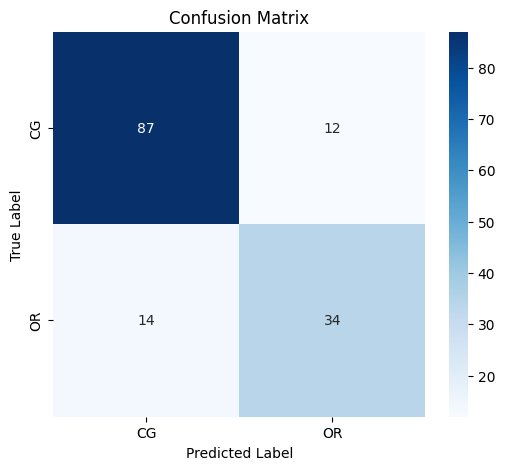

In [31]:
# Visualisasi confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['CG', 'OR'], yticklabels=['CG', 'OR'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Hasil menunjukkan angka yang cukup baik untuk penelitian deteksi ulasan palsu. Namun, belum optimal karena precision OR rendah dan ada tanda overfitting, yang dapat diperbaiki dengan penyesuaian berdasarkan langkah-langkah penelitian.